In [1]:
import tensorflow as tf
import random 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
x_train = mnist.train.images[:55000, :]
x_train.shape

(55000, 784)

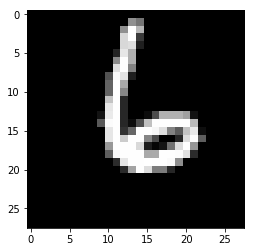

In [4]:
randomIndex = random.randint(0,55000)
image = x_train[randomIndex].reshape([28,28])
plt.imshow(image, cmap='gray')
plt.show()

In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1,1,1,1], padding="SAME")

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

def conv2d_transpose(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape=output_shape, strides=[1,2,2,1], padding='SAME')

In [6]:
def forward_pass_discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if(reuse):
            tf.get_variable_scope().reuse_variables()
        
        #ConvLayer 1: F=28, K=5, .Input Depth=1, Depth=8, S=1, (P=2)
        W_conv1 = tf.get_variable('d_wconv1', [5,5,1,8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        hidden_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        pool_conv1 = avg_pool_2x2(hidden_conv1)
        
        #ConvLayer 2: F=14, K=5, Input Depth = 8, Depth=16, S=1, (P=2)
        W_conv2 = tf.get_variable('d_wconv2', [5,5,8,16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        hidden_conv2 = tf.nn.relu(conv2d(pool_conv1, W_conv2) + b_conv2)
        pool_conv2 = avg_pool_2x2(hidden_conv2)
        pool_conv2_flatten = tf.reshape(pool_conv2, [-1,7*7*16])
        
        #FCL 1: Hidden neurons=input volume=7*7*16, output=32 activation=relu
        W_fc1 = tf.get_variable('d_wfc1', [7*7*16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        hidden_fc1 = tf.nn.relu(tf.matmul(pool_conv2_flatten, W_fc1) + b_fc1)
        
        #FCL 2: Hidden = 32, output=1 (binary classifier - +-0.5)
        W_fc2 = tf.get_variable('d_wfc2', [32,1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))
        output = (tf.matmul(hidden_fc1, W_fc2) + b_fc2)
        
    return output


In [7]:
def forward_pass_generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if(reuse):
            tf.get_variable_scope().reuse_variables()
        
        g_dim = 64 #Number of filters of first layer
        c_dim = 1 #Color dimension of output (gray_scale mnist = 1)
        s = 28 #Spatial output of image
        
        #Since we're upscaling to s from smaller vector, we'll define "checkpoints" along the way
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)
        
        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25]) #int(z_dim/batch_size)]) instead of 25 as in tut
        h0 = tf.nn.relu(h0) #shouldn't need this because there are already no negative pixel values (not centered); not to mention, why activate your inputs?
        
        #Conv Transpose 1: Input volume = batch_size x [2,2,25]
        output1_shape = [batch_size, s8, s8, g_dim * 4] #why g_dim * 4?
        W_conv1 = tf.get_variable('g_wconv1', [5,5,output1_shape[-1], int(h0.get_shape()[-1])], initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1)) #why .1 not 0?
        H_conv1 = conv2d_transpose(h0, W_conv1, output1_shape) + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs=H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        assert H_conv1.shape == (batch_size, 3,3,256)
        
        #Conv Transpose 2
        output2_shape = [batch_size, s4-1, s4-1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5,5,output2_shape[-1], int(H_conv1.get_shape()[-1])], initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv2 = conv2d_transpose(H_conv1, W_conv2, output2_shape) + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs=H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        assert H_conv2.shape == [batch_size, 6,6,128]
        
        #Conv Transpose 3
        output3_shape = [batch_size, s2-2, s2-2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5,5,output3_shape[-1], int(H_conv2.get_shape()[-1])], initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(0.1))
        H_conv3 = conv2d_transpose(H_conv2, W_conv3, output3_shape) + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs=H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        assert H_conv3.shape == [batch_size, 12, 12, 64]
        
        #Conv Transpose 4
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5,5,output4_shape[-1], int(H_conv3.get_shape()[-1])], initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = conv2d_transpose(H_conv3, W_conv4, output4_shape) + b_conv4
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        assert H_conv4.shape == [batch_size, 28, 28, 1]
        
    return H_conv4

Instructions for updating:
Colocations handled automatically by placer.


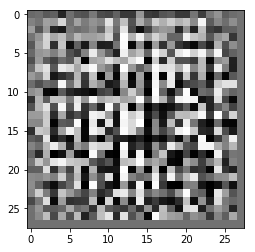

In [8]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

sample_image = forward_pass_generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.uniform(-1, 1, [1, z_dimensions])

sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [9]:
batch_size = 16
tf.reset_default_graph()

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape=[batch_size, 28,28,1])
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [10]:
Dx = forward_pass_discriminator(x_placeholder)
Gz = forward_pass_generator(z_placeholder, batch_size, z_dimensions)
Dg = forward_pass_discriminator(Gz, reuse=True)

In [11]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones(Dg.shape)))

In [12]:
dx_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones(Dx.shape)))
dg_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros(Dg.shape)))
d_loss = dx_loss + dg_loss

In [13]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [14]:
adam = tf.train.AdamOptimizer(learning_rate=0.002)
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

In [15]:
with tf.device('/gpu:0'):
    config = tf.ConfigProto(allow_soft_placement=True) 
    sess.run(tf.global_variables_initializer())
    iterations=10000
    for i in range(iterations):
        z_batch = np.random.uniform(-1,1,size=[batch_size, z_dimensions])
        real_image_batch = mnist.train.next_batch(batch_size)
        real_image_batch = np.reshape(real_image_batch[0], [batch_size, 28,28,1])
        _, dloss = sess.run([trainerD, d_loss], feed_dict={z_placeholder: z_batch, x_placeholder: real_image_batch})
        _, gloss = sess.run([trainerG, g_loss], feed_dict={z_placeholder: z_batch})

InvalidArgumentError: Cannot assign a device for operation init: node init (defined at <ipython-input-15-bd9991f2f054>:3) was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device. The requested device appears to be a GPU, but CUDA is not enabled.
	 [[node init (defined at <ipython-input-15-bd9991f2f054>:3) ]]

Caused by op 'init', defined at:
  File "C:\Users\Joel Bartlett\Miniconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 708, in __init__
    self.run()
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-bd9991f2f054>", line 3, in <module>
    sess.run(tf.global_variables_initializer())
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 2879, in global_variables_initializer
    return variables_initializer(global_variables())
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 2856, in variables_initializer
    return control_flow_ops.group(*[v.initializer for v in var_list], name=name)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3697, in group
    return _GroupControlDeps(dev, deps, name=name)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3649, in _GroupControlDeps
    return no_op(name=name)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\ops\gen_control_flow_ops.py", line 546, in no_op
    "NoOp", name=name)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\Joel Bartlett\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation init: node init (defined at <ipython-input-15-bd9991f2f054>:3) was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device. The requested device appears to be a GPU, but CUDA is not enabled.
	 [[node init (defined at <ipython-input-15-bd9991f2f054>:3) ]]


In [ ]:
sample_image = forward_pass_generator(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.uniform(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray')